## Import

In [1]:
import os
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

import warnings
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings(action='ignore') 

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':30,
    'LEARNING_RATE':1e-4,
    'WEIGHT_DECAY':1e-4,
    'BATCH_SIZE':128,
    'SEED':41
}
# CFG = {
#     'WIDTH':48,
#     'HEIGHT':72,
#     'WARMUP_EPOCHS': 5,
#     'WARMUP_LR': 1e-5,
#     'EPOCHS':40,
#     'LEARNING_RATE':1e-2,
#     'MIN_LR':1e-5,
#     'WEIGHT_DECAY':1e-4,
#     'BATCH_SIZE':128,
#     'SEED':41
# }

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [5]:
simulation_sem_paths = sorted(glob.glob('data/simulation_data/SEM/*/*/*.png'))
simulation_depth_paths = sorted(glob.glob('data/simulation_data/Depth/*/*/*.png')+glob.glob('data/simulation_data/Depth/*/*/*.png'))

In [6]:
data_len = len(simulation_sem_paths) # == len(simulation_depth_paths)

In [7]:
train_sem_paths = simulation_sem_paths[:int(data_len*0.8)]
train_depth_paths = simulation_depth_paths[:int(data_len*0.8)]

val_sem_paths = simulation_sem_paths[int(data_len*0.8):]
val_depth_paths = simulation_depth_paths[int(data_len*0.8):]

## CustomDataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list, transform=None):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        self.transform = transform
        
    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        
        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[index]
            depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
            transformed = self.transform(image=sem_img, mask=depth_img)
            sem_img = transformed['image']
            depth_img = (transformed['mask'].unsqueeze(0).float() - 127.5) / 127.5
            return sem_img, depth_img
        else:
            transformed = self.transform(image=sem_img)
            sem_img = transformed['image']
            img_name = sem_path.split('/')[-1]
            return sem_img, img_name # B,C,H,W
        
    def __len__(self):
        return len(self.sem_path_list)

In [9]:
train_transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5), std=(0.5)),
    ToTensorV2(),
])
train_dataset = CustomDataset(train_sem_paths, train_depth_paths, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=8)

valid_transform = A.Compose([
    A.Normalize(mean=(0.5), std=(0.5)),
    ToTensorV2(),
])
val_dataset = CustomDataset(val_sem_paths, val_depth_paths, valid_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=8)

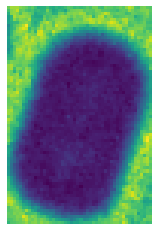

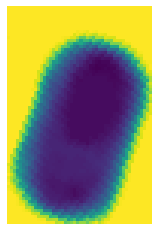

In [10]:
import matplotlib.pyplot as plt

def show_img(img):
    img = img.permute(1, 2, 0)*127.5 + 127.5
    plt.imshow(img)
    plt.axis('off')
    plt.show()

sem, depth = train_dataset[0]
show_img(sem)
show_img(depth)

## Model Define

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class ConvBN(nn.Sequential):
    def __init__(self, in_ch, out_ch, k, s=1, p=0):
        super().__init__(nn.Conv2d(in_ch, out_ch, k, s, p), nn.BatchNorm2d(out_ch))


class PSP(nn.Module):
    def __init__(self, ch, pool_scale=(1,2,3,6)):
        super().__init__()
        self.pool_scale = pool_scale
        self.conv_list = nn.ModuleList([ConvBN(ch, ch, 1) for _ in range(len(pool_scale))])
        self.cat = ConvBN(ch + len(pool_scale) * ch, ch, 3, 1, 1)

    def forward(self, x):
        _, _, H, W = x.shape
        multi_scale = [x] 
        for scale, conv in zip(self.pool_scale, self.conv_list):
            single_scale = F.avg_pool2d(x, scale)
            single_sclae = conv(single_scale) 
            single_scale = F.interpolate(single_scale, (H, W))
            multi_scale.append(single_scale)
        out = self.cat(torch.cat(multi_scale, dim=1))
        return out


class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.psp = PSP(64)
        self.outc = OutConv(64, n_classes)

        self.init_weight()

    def init_weight(self, zero_init_last=True):
        for m in self.named_modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.psp(x)
        logits = self.outc(x)
        return logits

## Train

In [12]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    model = model.to(memory_format=torch.channels_last)

    criterion = nn.L1Loss().to(device)
    best_score = 999999
    best_model = None

    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for sem, depth in tqdm(iter(train_loader)):
            sem = sem.float().to(device)
            sem = sem.to(memory_format=torch.channels_last)
            depth = depth.float().to(device)
            
            optimizer.zero_grad()
            
            with torch.cuda.amp.autocast(True):
                model_pred = model(sem)
                loss = criterion(model_pred, depth)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_rmse = validation(model, criterion, val_loader, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val RMSE : [{val_rmse:.5f}]')
        
        if best_score > val_rmse:
            best_score = val_rmse
            best_model = model
        
        if scheduler is not None:
            scheduler.step()
            
    return best_model

In [13]:
def validation(model, criterion, val_loader, device):
    model.eval()
    rmse = nn.MSELoss().to(device)
    
    val_loss = []
    val_rmse = []
    with torch.no_grad():
        for sem, depth in tqdm(iter(val_loader)):
            sem = sem.float().to(device)
            depth = depth.float().to(device)
            
            with torch.cuda.amp.autocast(True):
                model_pred = model(sem)
                loss = criterion(model_pred, depth)
            
            pred = (model_pred*127.5+127.5).type(torch.int8).float()
            true = (depth*127.5+127.5).type(torch.int8).float()
            
            b_rmse = torch.sqrt(criterion(pred, true))
            
            val_loss.append(loss.item())
            val_rmse.append(b_rmse.item())

    return np.mean(val_loss), np.mean(val_rmse)

## Run!!

In [14]:
model = UNet()
model.eval()

# AdamW + OneCycleLR
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=CFG["WEIGHT_DECAY"])
iter_per_epoch = (len(train_dataset) // CFG["BATCH_SIZE"] + 1)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, CFG["LEARNING_RATE"], total_steps=iter_per_epoch * CFG["EPOCHS"])

# SGD + WarmupCosine
# optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=CFG["WEIGHT_DECAY"], momentum=0.9, nesterov=True)
# iter_per_epoch = (len(train_dataset) // CFG["BATCH_SIZE"] + 1)
# main_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, (CFG["EPOCHS"] - CFG["WARMUP_EPOCHS"]) * iter_per_epoch, CFG["MIN_LR"]) 
# warmup_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: e * (CFG["LEARNING_RATE"] - CFG["WARMUP_LR"]) / (CFG["WARMUP_EPOCHS"] * iter_per_epoch) + CFG["WARMUP_LR"])
# scheduler = optim.lr_scheduler.SequentialLR(optimizer, [warmup_scheduler, main_scheduler], [CFG["WARMUP_EPOCHS"] * iter_per_epoch])

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.10716] Val Loss : [0.05202] Val RMSE : [3.11944]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.04219] Val Loss : [0.04425] Val RMSE : [2.90639]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.03504] Val Loss : [0.03465] Val RMSE : [2.51137]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.03176] Val Loss : [0.03264] Val RMSE : [2.46057]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.02973] Val Loss : [0.03501] Val RMSE : [2.54947]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.02821] Val Loss : [0.03230] Val RMSE : [2.41085]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.02716] Val Loss : [0.02685] Val RMSE : [2.23146]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.02607] Val Loss : [0.02520] Val RMSE : [2.18539]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.02537] Val Loss : [0.02540] Val RMSE : [2.16799]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.02467] Val Loss : [0.03709] Val RMSE : [2.67525]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.02417] Val Loss : [0.02590] Val RMSE : [2.17071]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.02364] Val Loss : [0.02646] Val RMSE : [2.20469]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.02328] Val Loss : [0.02287] Val RMSE : [2.07713]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.02300] Val Loss : [0.02395] Val RMSE : [2.11303]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.02261] Val Loss : [0.02132] Val RMSE : [1.96755]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.02219] Val Loss : [0.02222] Val RMSE : [2.04126]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.02195] Val Loss : [0.02372] Val RMSE : [2.11273]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.02163] Val Loss : [0.02107] Val RMSE : [1.96141]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.02127] Val Loss : [0.03076] Val RMSE : [2.46369]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.02110] Val Loss : [0.02582] Val RMSE : [2.16163]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.02085] Val Loss : [0.02871] Val RMSE : [2.32509]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [22] Train Loss : [0.02062] Val Loss : [0.02173] Val RMSE : [1.99365]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [23] Train Loss : [0.02044] Val Loss : [0.03292] Val RMSE : [2.50350]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [24] Train Loss : [0.02027] Val Loss : [0.02425] Val RMSE : [2.12909]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [25] Train Loss : [0.02003] Val Loss : [0.02253] Val RMSE : [2.04671]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [26] Train Loss : [0.01982] Val Loss : [0.02214] Val RMSE : [2.04261]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [27] Train Loss : [0.01963] Val Loss : [0.02815] Val RMSE : [2.26854]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [28] Train Loss : [0.01948] Val Loss : [0.02243] Val RMSE : [2.07227]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [29] Train Loss : [0.01931] Val Loss : [0.02101] Val RMSE : [1.96661]


  0%|          | 0/1084 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

Epoch : [30] Train Loss : [0.01911] Val Loss : [0.02273] Val RMSE : [2.08424]


## Inference & Submission

In [15]:
test_sem_path_list = sorted(glob.glob('data/test/SEM/*.png'))

In [16]:
test_transform = A.Compose([
    A.Normalize(mean=(0.5), std=(0.5)),
    ToTensorV2(),
])
test_dataset = CustomDataset(test_sem_path_list, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [17]:
import zipfile
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():
        for sem, name in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            model_pred = model(sem)
            
            for pred, img_name in zip(model_pred, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*127.5+127.5
                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)
                result_list.append(pred)
    
    os.makedirs('./submission', exist_ok=True)
    os.chdir("./submission/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("../submission.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [18]:
inference(infer_model, test_loader, device)

  0%|          | 0/204 [00:00<?, ?it/s]